In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import IPython
from IPython import display
import pylab as pl
from scipy.io import wavfile
import pywt
from brian2 import *
from brian2hears import *

from ICA import *
from general_utils import *
from visualization_utils import * 
from bss_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Sound Separation'

In [2]:
sound_paths = '../../data/Sounds'
sounds = []

rate, a = wavfile.read(os.path.join(sound_paths, 'MA02_04.wav'))
rate, b = wavfile.read(os.path.join(sound_paths, 'MH43_06.wav'))
rate, c = wavfile.read(os.path.join(sound_paths, 'MH43_09.wav'))
rate, d = wavfile.read(os.path.join(sound_paths, 'FA01_03.wav'))
rate, e = wavfile.read(os.path.join(sound_paths, 'FJ55_04.wav'))
rate, f = wavfile.read(os.path.join(sound_paths, 'MD19_07.wav'))
rate, g = wavfile.read(os.path.join(sound_paths, 'MH43_08.wav'))

a = a.astype('float64')
b = b.astype('float64')
c = c.astype('float64')
d = d.astype('float64')
e = e.astype('float64')
f = f.astype('float64')
g = g.astype('float64')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)
f_max = np.max(f)
g_max = np.max(g)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max
f /= f_max
g /= g_max

shortest = min(len(a), len(b), len(c),  len(d),  len(e), len(f), len(g))
a = a[:shortest]#[:,0]
b = b[:shortest]#[:,0]
c = c[:shortest]#[:,0]
d = d[:shortest]
e = e[:shortest]
f = f[:shortest]
g = g[:shortest]

all_sound_data = np.stack((a, b, c, d, e, f, g))

print(all_sound_data.shape)
display_matrix(np.corrcoef(all_sound_data))

(7, 32851)


<IPython.core.display.Math object>

In [3]:
def compute_vectorized_gammatone_of_rows(S, samplerate, n_center_frequencies, time_constant_of_filters = 1.019,
                                         min_freq = 20, max_freq = 20000, power_normalization_in_freq_domain = False):
    n_sources = S.shape[0]
    n_samples = S.shape[1]
    b1 =time_constant_of_filters
    center_frequencies = erbspace(min_freq*Hz, max_freq*Hz, n_center_frequencies)
    
    GammaToneMatrix = np.zeros((n_sources, n_samples * n_center_frequencies))
    
    for jj in range(n_sources):
        gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
        gt_mon = gammatone.process().T
        GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    
    gamma_tone_max = np.abs(GammaToneMatrix).max(axis = 1).reshape(-1,1)
    S = S / gamma_tone_max
    if power_normalization_in_freq_domain:
        for jj in range(n_sources):
            gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
            gt_mon = gammatone.process().T
            GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    return GammaToneMatrix, gamma_tone_max

In [4]:
# np.random.seed(431)

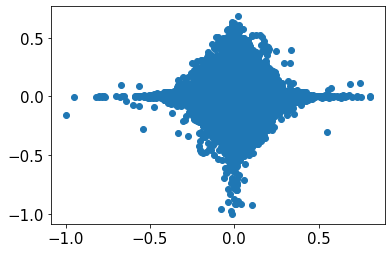

In [5]:
S = all_sound_data[np.random.choice(all_sound_data.shape[0], size=3, replace=False, p=None),:]
nbr_center_frequencies = 10
b1 = 1.019  #factor determining the time constant of the filters

S_gammaTone, S_gammaToneMax = compute_vectorized_gammatone_of_rows(S, samplerate = 16000, 
                                                                   n_center_frequencies = nbr_center_frequencies,
                                                                   time_constant_of_filters = b1, 
                                                                   min_freq = 20, max_freq = 20000, 
                                                                   power_normalization_in_freq_domain = True)
S = S / S_gammaToneMax

plt.scatter(S_gammaTone[0,:], S_gammaTone[1,:])

In [6]:
NumberofMixtures = 5
NumberofSources = S.shape[0]

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

Xnoisy, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 40.018446262367604
Row standard deviation of mixtures : [0.32721318 0.8462122  0.27453321 0.51631533 0.48354118]


In [7]:
X_gammaTone, _ = compute_vectorized_gammatone_of_rows( X, samplerate = 16000, 
                                                       n_center_frequencies = nbr_center_frequencies,
                                                       time_constant_of_filters = b1, 
                                                       min_freq = 20, max_freq = 20000, 
                                                       power_normalization_in_freq_domain = False)

# In Time Domain

In [8]:
Y = fit_icainfomax(
                    X,
                    NumberofSources)

Creating RawArray with float64 data, n_channels=5, n_times=32851
    Range : 0 ... 32850 =      0.000 ...    16.425 secs
Ready.


In [9]:
W_ICA = (Y @ np.linalg.pinv(X))

In [10]:
Y = W_ICA @ X
Y = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y * S).sum(axis=1) / (Y * Y).sum(axis=1)).reshape(-1, 1)
Y = coef_ * Y

SNR_levels = snr(S, Y)
    
SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component SNR Values : {}\n".format(SNR_levels))
print("Overall SINR : {}".format(SINR))

Component SNR Values : [33.18484765 40.74617936 53.93828044]

Overall SINR : 37.10732795126381


# With GammaTone

In [11]:
Y_gammaTone = fit_icainfomax(
                                X_gammaTone,
                                NumberofSources)

Creating RawArray with float64 data, n_channels=5, n_times=328510
    Range : 0 ... 328509 =      0.000 ...   164.255 secs
Ready.


In [12]:
W_ICA = (Y_gammaTone @ np.linalg.pinv(X_gammaTone))

In [13]:
Y = W_ICA @ X
Y = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y * S).sum(axis=1) / (Y * Y).sum(axis=1)).reshape(-1, 1)
Y = coef_ * Y

SNR_levels = snr(S, Y)
    
SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component SNR Values : {}\n".format(SNR_levels))
print("Overall SINR : {}".format(SINR))

Component SNR Values : [36.17273457 44.25999994 52.96124429]

Overall SINR : 40.169216847201454


In [14]:
# Y_gammaTone = signed_and_permutation_corrected_sources(S_gammaTone,Y_gammaTone)
# coef_ = ((Y_gammaTone * S_gammaTone).sum(axis=1) / (Y_gammaTone * Y_gammaTone).sum(axis=1)).reshape(-1, 1)
# Y_gammaTone = coef_ * Y_gammaTone

# # ICA_GammaTone_Matrix = 
# SNR_levels = snr(S_gammaTone, Y_gammaTone)

# SINR = 10*np.log10(CalculateSINRjit(Y_gammaTone, S_gammaTone, False)[0])
# print("Component SNR Values : {}\n".format(SNR_levels))
# print("Overall SINR : {}".format(SINR))